In [2]:
import sys
import sqlite3 as sql
import importlib

from math import *;
from os.path import basename;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

import numpy as np
import geom
import matplotlib.image as image
import matplotlib.pyplot as plt
import importlib
import sonalleve 
import transducers

import MRDataAnalysis
from MRDataAnalysis import rescale as rescaleIm
#from matplotlib.mlab import griddata

import matplotlib.transforms as mpl_trans

import scipy.interpolate as snt
import scipy.ndimage.filters as sflt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import nibabel
import visvis as vv
#os.chdir('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\path_optimization\\')

%matplotlib inline
np.set_printoptions(precision=4, suppress=True, threshold=1300)

plt.rc('font', family='sans-serif', size=20)

In [271]:
importlib.reload(MRDataAnalysis)

<module 'MRDataAnalysis' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\MRDataAnalysis.py'>

In [1348]:
file1="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan25_TempCor_20160413.PAR" 
file2="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan26_TempCor_20160413.PAR"

(tempdata1,complIm1,im1, dyntimes1)= MRDataAnalysis.read_TempScan(file1,MP_interleaved=True, phase_unwrap=0, pi_val=-0.2)
(tempdata2,complIm2,im2, dyntimes2)= MRDataAnalysis.read_TempScan(file2,MP_interleaved=True, phase_unwrap=0, pi_val=-0.2)

aff1 = im1.get_affine()
aff2 = im2.get_affine()
invAff1 =np.linalg.inv(aff1 )
invAff2 =np.linalg.inv(aff2 )

TempRAS_dmm = np.abs( aff1.dot([1,1,1,0]) )[0:3]

In [1349]:
file3 = "/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan27_TempCor_20160413.PAR"
(tempdata3,complIm3,im3, dyntimes3)= MRDataAnalysis.read_TempScan(file3,MP_interleaved=True, phase_unwrap=0, pi_val=-0.2)


array([[ -0.5631,  -0.    ,  -0.    ,  54.906 ],
       [ -0.    ,  -0.    ,  -0.5631,  53.6525],
       [ -0.    ,  -0.25  ,   0.    ,   1.989 ],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

In [1350]:
pos1etc = dict(color=(0., 0.6, 0.6))
pos2etc = dict(color=(0.9, 0.4, 0.8))

focus1_LPH = np.array([-1., 14., 12])
focus2_LPH = np.array([-1., 14., -12])

focus1_RAS = MRDataAnalysis.LPH_to_RAS().dot(focus1_LPH)
focus2_RAS = MRDataAnalysis.LPH_to_RAS().dot(focus2_LPH)

focus1_MPSf = (invAff1[0:3,0:3].dot(focus1_RAS) + invAff1[0:3,3])
focus2_MPSf = (invAff1[0:3,0:3].dot(focus2_RAS) + invAff1[0:3,3])
focus1_MPS=np.floor(focus1_MPSf).astype(int)
focus2_MPS=np.floor(focus2_MPSf).astype(int)

roiPos1Mr = np.round(focus1_MPSf[0] + np.arange(-3,4)).astype(int)
roiPos1Pr = np.round(focus1_MPSf[1] + np.arange(-3,4)).astype(int)
roiPos1Sr = np.round(focus1_MPSf[2] + np.arange(0,3)).astype(int)
roiPos1Sr = np.array([4,5,6,7])

roiPos2Mr = np.round(focus2_MPSf[0] + np.arange(-3,4)).astype(int)
roiPos2Pr = np.round(focus2_MPSf[1] + np.arange(-3,4)).astype(int)
roiPos2Sr = np.round(focus2_MPSf[2] + np.arange(0,3)).astype(int)
roiPos2Sr = np.array([4,5,6,7])


roiRAS1 = geom.rotate_mesh_volume(aff1[0:3,0:3], *np.meshgrid(roiPos1Mr.astype(float), roiPos1Pr, roiPos1Sr,indexing='ij'),translate=aff1[0:3,3],squeeze=False)
roiRAS2 = geom.rotate_mesh_volume(aff1[0:3,0:3], *np.meshgrid(roiPos2Mr.astype(float), roiPos2Pr, roiPos2Sr,indexing='ij'),translate=aff1[0:3,3],squeeze=False)


In [240]:
focus1_MPSf

array([  95.737 ,  -40.0418,  120.1516])

In [241]:
focus2_MPSf

array([ 54.3429,  60.4094,   5.489 ])

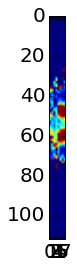

In [418]:
plt.imshow( tempdata1[54,:,:,32],vmin=0,vmax=10)

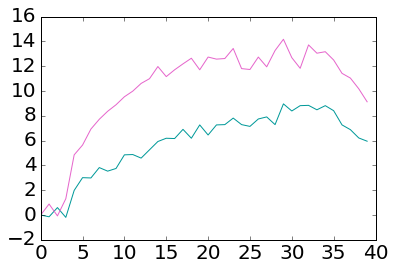

In [983]:
plt.plot( tempdata2[focus1_MPS[0], focus1_MPS[1], focus1_MPS[2]], color=pos1etc['color'] )
plt.plot( tempdata2[focus2_MPS[0], focus2_MPS[1], focus2_MPS[2]], color=pos2etc['color'])


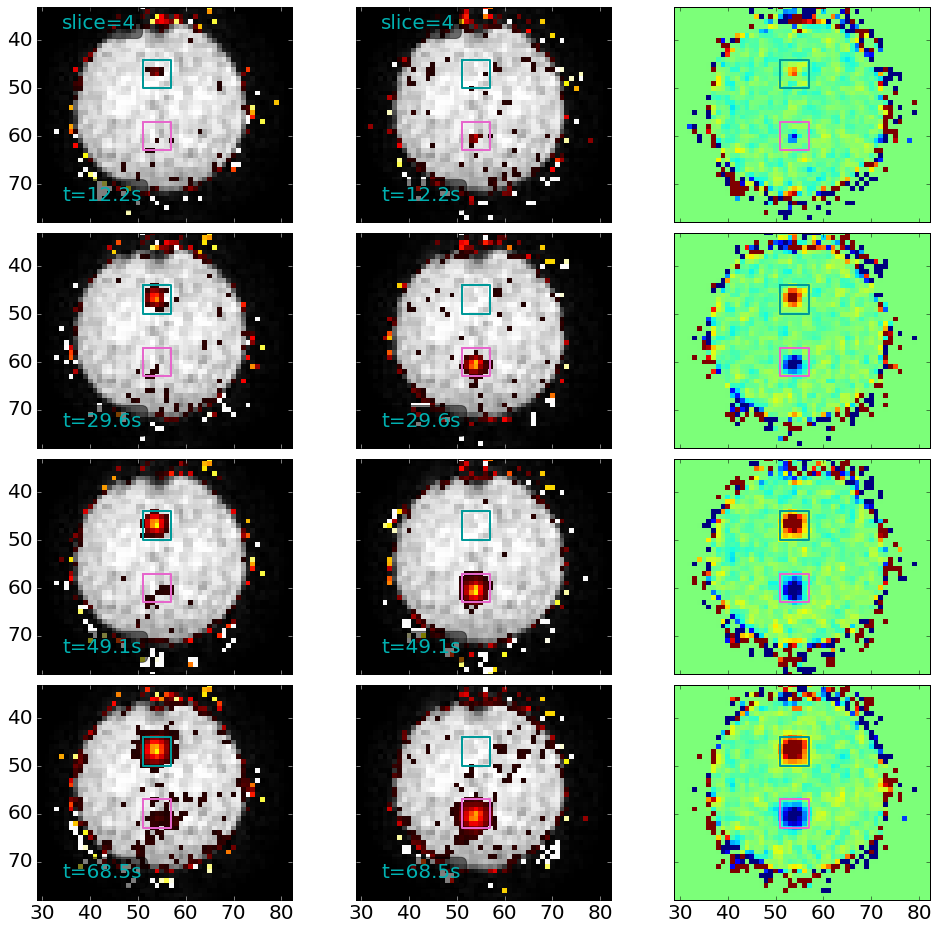

In [947]:
Si = 4
magDyn=2

magImg = rescaleIm( np.abs(complIm1[:,:,Si,magDyn]).transpose() )


dyns=[6,15,25,35]
#dyns=[3,6,8]
#dyns=[2,3,4,5,6,7,8]

#,subplot_kw=dict(xlim=[20,80],ylim=[80,20])


xlim=np.floor(tempdata1.shape[1]*np.array([1./2 - 1./5, 1./2 + 1./5]))
ylim=np.floor(tempdata1.shape[0]*np.array([1./2 + 1./5, 1./2 - 1./5]))
fig,axTable=plt.subplots(nrows=len(dyns),ncols=3,subplot_kw=dict(xlim=xlim,ylim=ylim),
                         sharey=True,sharex=True,squeeze=False,gridspec_kw=dict(wspace=0.25,hspace=0.05), 
                         figsize=(16,16))

sets = [(tempdata1,complIm1,im1, dyntimes1), (tempdata2,complIm2,im2, dyntimes2)]

props = dict(boxstyle='round', facecolor='black', alpha=0.5)

slc=Si
for di in range(len(dyns)):
    dyn=dyns[di]
    for col in range(2):

        data = sets[col][0]
        
        ax=axTable[di,col]
        data1=data[:,:,slc,dyn].transpose() 
        mask1 =  data1 < 1.0 
        
        rgbaIm1 = image.cm.hot( rescaleIm(data1, vmin=0,vmax=30,trunc=True) )
        rgbaIm1[mask1,3]=0
        
        ax.imshow(magImg, cmap=image.cm.gray, vmin=0.0, vmax=0.95, interpolation='none')
        im=ax.imshow(rgbaIm1, interpolation='none')
        ax.tick_params(color='w')
        
        ax.plot( roiPos1Mr[[0,0,-1,-1,0]], roiPos1Pr[[0,-1,-1,0,0]], '-',linewidth=2.0, color=pos1etc['color']  )
        ax.plot( roiPos2Mr[[0,0,-1,-1,0]], roiPos2Pr[[0,-1,-1,0,0]], '-',linewidth=2.0, color=pos2etc['color']  )
        if di==0:
            plt.text(0.1,0.9,'slice=%d'%slc, color=(0,.7,.7),transform=ax.transAxes,bbox=props)
        
        plt.text(0.1,0.1,'t=%0.1fs'%dyntimes1[dyn], color=(0,.7,.7),transform=ax.transAxes,bbox=props)
        
    #col 3
    ax=axTable[di,2]
    diff = (sets[0][0][:,:,slc,dyn] - sets[1][0][:,:,slc,dyn] ).transpose() 
    im=ax.imshow(diff, vmin=-10,vmax=10, interpolation='none')
    ax.plot( roiPos1Mr[[0,0,-1,-1,0]], roiPos1Pr[[0,-1,-1,0,0]], '-',linewidth=2.0, color=pos1etc['color']  )
    ax.plot( roiPos2Mr[[0,0,-1,-1,0]], roiPos2Pr[[0,-1,-1,0,0]], '-',linewidth=2.0, color=pos2etc['color']  )

In [197]:
def getRoiTemps(tempdata):
    avgTempPos1 = np.mean( tempdata[np.ix_(roiPos1Mr,roiPos1Pr,roiPos1Sr)], axis=(0,1,2) )
    maxTempPos1 = np.max( tempdata[np.ix_(roiPos1Mr,roiPos1Pr,roiPos1Sr)], axis=(0,1,2) )
    avgTempPos2 = np.mean( tempdata[np.ix_(roiPos2Mr,roiPos2Pr,roiPos2Sr)], axis=(0,1,2) )
    maxTempPos2 = np.max( tempdata[np.ix_(roiPos2Mr,roiPos2Pr,roiPos2Sr)], axis=(0,1,2) )
    
    return (avgTempPos1,maxTempPos1,avgTempPos2,maxTempPos2)

(0.0, 12.0)

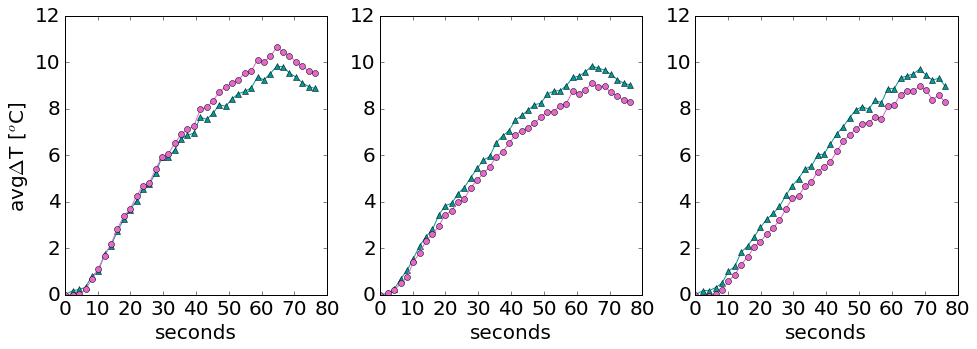

In [1351]:
(avg1pos1,max1pos1,avg1pos2,max1pos2)=getRoiTemps(tempdata1)
(avg2pos1,max2pos1,avg2pos2,max2pos2)=getRoiTemps(tempdata2)
(avg3pos1,max3pos1,avg3pos2,max3pos2)=getRoiTemps(tempdata3)

fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(131)
ax.plot( dyntimes1,avg1pos1,'-^', color=pos1etc['color'] )
ax.plot( dyntimes1,avg1pos2,'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
ax.set_ylabel(r'avg$\Delta$T [$^o$C]')

xlim=ax.get_xlim()
ylim=ax.get_ylim()

ax=fig.add_subplot(132)
ax.plot( dyntimes2,avg2pos1,'-^', color=pos1etc['color'] )
ax.plot( dyntimes2,avg2pos2,'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax=fig.add_subplot(133)
ax.plot( dyntimes3,avg3pos1,'-^', color=pos1etc['color'] )
ax.plot( dyntimes3,avg3pos2,'-o', color=pos2etc['color'] )
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

(0.0, 45.0)

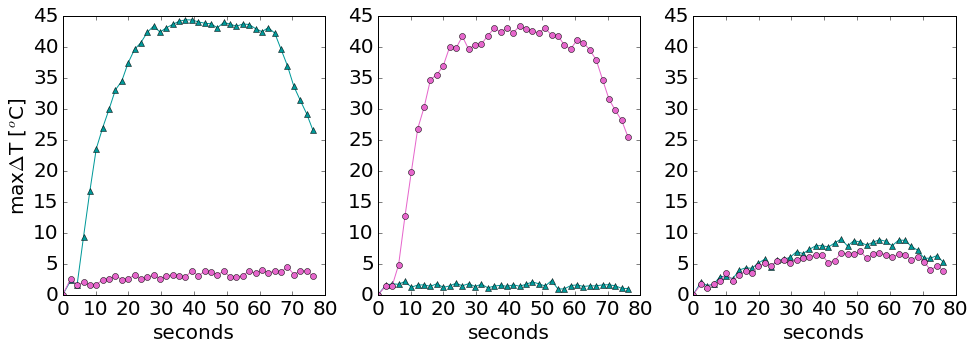

In [1342]:
fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(131)
ax.plot( dyntimes1,max1pos1,'-^', color=pos1etc['color'] )
ax.plot( dyntimes1,max1pos2,'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
ax.set_ylabel(r'max$\Delta$T [$^o$C]')

xlim=ax.get_xlim()
ylim=ax.get_ylim()

ax=fig.add_subplot(132)
ax.plot( dyntimes2,max2pos1,'-^', color=pos1etc['color'] )
ax.plot( dyntimes2,max2pos2,'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax=fig.add_subplot(133)
ax.plot( dyntimes3,max3pos1,'-^', color=pos1etc['color'] )
ax.plot( dyntimes3,max3pos2,'-o', color=pos2etc['color'] )
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [1352]:
t1wfile=parfil="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan28_T1wPhantomSag_20160413.PAR"
t1wObj=nibabel.load(t1wfile,scaling='fp')


t1wData=rescaleIm(t1wObj.get_data())
#t2SmallestFilledVal = np.min(t2wData[t2wData>0])
#t1wData= rescaleIm( t1wData, newmin=0.0, vmin=t1SmallestFilledVal, trunc=True )

t1aff=t1wObj.get_affine()
t1invaff = np.linalg.inv(t1aff)
t1wvox0=np.arange(0,t1wData.shape[0])
t1wvox1=np.arange(0,t1wData.shape[1])
t1wvox2=np.arange(0,t1wData.shape[2])

t1wDX,t1wDY,t1wDZ,junk=np.abs(t1aff.dot([1.0,1.0,1.0,0]))

t1wData.shape

(352, 352, 94)

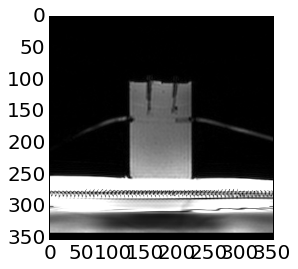

In [536]:
t1wsliceM=t1wvox0
t1wsliceP=t1wvox1
t1wsliceS=np.array([49,50,51])
plt.imshow( image.cm.gray(rescaleIm(t1wData[np.ix_(t1wsliceM,t1wsliceP,t1wsliceS[[0]])].squeeze(),vmax=0.2)) )

In [1358]:
t1MPSmesh = np.meshgrid(t1wsliceM.astype(float),t1wsliceP,t1wsliceS, indexing='ij')
t1RASmesh_mm = geom.rotate_mesh_volume(t1aff[0:3,0:3], *t1MPSmesh, translate=t1aff[0:3,3], squeeze=False)

TempM = np.array([53,54,55,56])
#TempM = roiPos1Mr
TempP = np.arange(0,tempdata1.shape[1],dtype=int)
TempS = np.arange(0,tempdata1.shape[2],dtype=int)
#TempS = np.array([5])
TempMPSmesh = np.meshgrid(TempM.astype(float),TempP.astype(float),TempS.astype(float), indexing='ij')
TempRASmesh_mm = geom.rotate_mesh_volume(aff1[0:3,0:3], *TempMPSmesh, translate=aff1[0:3,3], squeeze=False)
TempToT1mesh = geom.rotate_mesh_volume(t1invaff[0:3,0:3], *TempRASmesh_mm, translate=t1invaff[0:3,3], squeeze=False )
#temppoints = np.array([TempToT1mesh[0].flatten(), TempToT1mesh[1].flatten(), TempToT1mesh[2].flatten()]).transpose() 

temppoints = np.array([TempRASmesh_mm[0].flatten(), TempRASmesh_mm[1].flatten(), TempRASmesh_mm[2].flatten()]).transpose() 

dyn=15
Tsegment1=np.squeeze(tempdata1[np.ix_(TempM,TempP,TempS,[dyn])])
Tsegment2=np.squeeze(tempdata2[np.ix_(TempM,TempP,TempS,[dyn])])
Tsegment3=np.squeeze(tempdata3[np.ix_(TempM,TempP,TempS,[dyn])])

In [710]:
roiPos1Mr

array([51, 52, 53, 54, 55, 56, 57])

In [1359]:
interpTempOnT11 = snt.griddata(temppoints, Tsegment1.flatten(), t1RASmesh_mm, fill_value=0, method='linear' )

In [1360]:
interpTempOnT12 = snt.griddata(temppoints, Tsegment2.flatten(), t1RASmesh_mm, fill_value=0, method='linear' )

In [1361]:
interpTempOnT13 = snt.griddata(temppoints, Tsegment3.flatten(), t1RASmesh_mm, fill_value=0, method='linear' )

In [655]:
interpTempOnT1.shape

(352, 352, 3)

In [1327]:
r1=tuple(map( lambda dx,x: [np.min(x)-dx*0.5,np.max(x)+dx*0.5], TempRAS_dmm,
             geom.rotate_mesh_volume(t1invaff[0:3,0:3], *roiRAS1, translate=t1invaff[0:3,3], squeeze=False ) ))
r2=tuple(map( lambda dx,x: [np.min(x)-dx*0.5,np.max(x)+dx*0.5], TempRAS_dmm,
             geom.rotate_mesh_volume(t1invaff[0:3,0:3], *roiRAS2, translate=t1invaff[0:3,3], squeeze=False ) ))

r1=tuple(map( lambda dx,x: [np.min(x)-dx*0.5,np.max(x)+dx*0.5], TempRAS_dmm, roiRAS1))
r2=tuple(map( lambda dx,x: [np.min(x)-dx*0.5,np.max(x)+dx*0.5], TempRAS_dmm, roiRAS2))


In [1328]:
nM,nP,nS=len(t1wsliceM),len(t1wsliceP),len(t1wsliceS)

#determine which RAS is are principle wrt to M,P image axes
whichAx_P=np.argmax( np.abs(t1aff.dot([0,1,0,0])) )
whichAx_M=np.argmax( np.abs(t1aff.dot([1,0,0,0])) )


Pax_mm=t1aff.dot( np.array( [np.zeros(nP)+t1wsliceM[0], t1wsliceP, np.zeros(nP)+t1wsliceS[0], np.ones(nP)]) )[whichAx_P]
Max_mm=t1aff.dot( np.array( [t1wsliceM, np.zeros(nM)+t1wsliceP[0], np.zeros(nM)+t1wsliceS[0], np.ones(nM)]) )[whichAx_M]


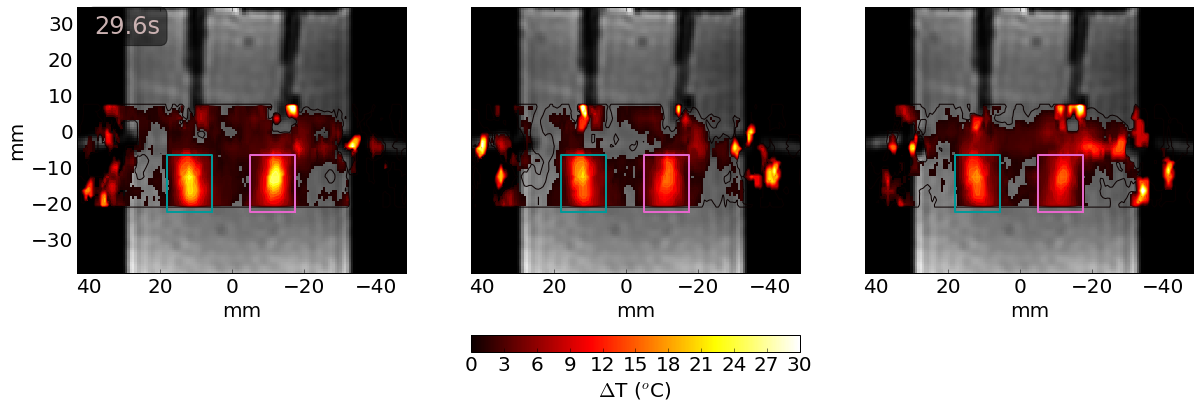

In [1362]:
def plotBox(h,xminmax, yminmax,**kwargs):
    xx=[ xminmax[0],xminmax[0], xminmax[1], xminmax[1], xminmax[0]]
    yy=[ yminmax[0],yminmax[1], yminmax[1], yminmax[0], yminmax[0]]
    return h.plot(xx,yy,**kwargs)

Si=0

LRBText=[Pax_mm[0],Pax_mm[-1],Max_mm[-1],Max_mm[0] ]


def plotstuff(ax,temp2d,Si=0,maxT=20):
    img=plt.imshow(t1wData[np.ix_(t1wsliceM,t1wsliceP,t1wsliceS[[Si]])].squeeze()**2, vmin=0.0,vmax=0.017,
                   extent=LRBText,
                   cmap=image.cm.gray, interpolation='none' )
    #temp2d=interpTempOnT11[:,:,Si]
    ax.contour(Pax_mm, Max_mm, temp2d, np.arange(0,maxT,2), cmap=image.cm.hot)

    mask = temp2d < 1.0
    rgbaIm = image.cm.hot( rescaleIm(temp2d, vmin=0,vmax=maxT,trunc=True) )
    rgbaIm[mask,3]=0
    ax.imshow(rgbaIm, interpolation='none',extent=LRBText )

    plotBox(plt, r1[whichAx_P],r1[whichAx_M],color=pos1etc['color'], linewidth=2.0 )
    plotBox(plt, r2[whichAx_P],r2[whichAx_M],color=pos2etc['color'], linewidth=2.0  )

    ax.set_xlim( (LRBText[1]-LRBText[0])*np.array([1./2 - 1./5, 1./2 + 1./5]) + LRBText[0])
    ax.set_ylim( (LRBText[3]-LRBText[2])*np.array([1./2 - 1./8, 1./2 + 1./5]) + LRBText[2])
    ax.set_aspect(1)
    ax.set_xlabel('mm')
    return ax

fig=plt.figure(figsize=(20,10))

ax=plt.subplot(131)
plotstuff(ax,interpTempOnT11[:,:,Si],Si=Si,maxT=30)
ax.set_ylabel('mm')
plt.text(0.05,0.9,'%0.1fs'%dyntimes1[dyn], color=(.8,.7,.7),transform=ax.transAxes,fontsize=24,
         bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

ax=plt.subplot(132)
ax.yaxis.set_visible(False)
plotstuff(ax,interpTempOnT12[:,:,Si],Si=Si,maxT=30)
ax2=ax

ax=plt.subplot(133,label='3')
ax.yaxis.set_visible(False)
plotstuff(ax,interpTempOnT13[:,:,Si],Si=Si,maxT=30)

im = ax.imshow(interpTempOnT11[:,:,Si], vmin=0,vmax=30, cmap=image.cm.hot)
im.set_visible(False)

#cbax=fig.add_axes([0.4,0.9,0.2,0.1])
cbax=fig.add_axes(ax2.get_position(),label='cb',frameon=False)
cbax.set_visible(False)
cb = plt.colorbar(ax=cbax,mappable=im,orientation='horizontal',shrink=1.0)
cb.set_label('$\Delta$T ($^o$C)')

In [1084]:
bbox=ax.get_position()
bbox.bounds

(0.67205882352941182,
 0.32729779411764703,
 0.22794117647058831,
 0.37040441176470595)

### FISO data

In [401]:
import re;
import csv;
import datetime


def floatFieldFmt(values):
    nv=len(values)
    return [ 0.0 if v=='NO SIGNAL' or len(v)==0 else float(v) for v in values ]

def readFISO(filename, nmax=None):
    
    csvfile=open(filename)
    reader=csv.reader(csvfile,delimiter='\t')
    text=list(reader)
    csvfile.close()
    
    nlines = len(text)
    if nmax is not None:
        if nmax < nlines:
            nlines=nmax
    
    i=0
    while (i<nlines):
        if len(text[i])>1 and re.search( 'Date/Time', text[i][0] ) and re.search( 'Channel', text[i][1] ):
            i+=1
            break;
        i+=1
        
    #ignore last line
    nlines=nlines-1
    
    fmt='%Y-%m-%d %H:%M:%S.%f'
    t0 = datetime.datetime.strptime(text[i][0],fmt)
    
    times = np.array(list(map( lambda x: (datetime.datetime.strptime(x[0],fmt) - t0).total_seconds(), text[i:nlines] )))
    
    data = np.array( list(map( lambda x: floatFieldFmt(x[1:5]), text[i:nlines] )), dtype='float')
    
    return (times, data)

In [1105]:
fiso1="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/SonalleveFiso/scan25.txt"
fiso2="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/SonalleveFiso/scan26.txt"
fiso3="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/SonalleveFiso/scan27.txt"
(times1,data1)=readFISO(fiso1)
(times2,data2)=readFISO(fiso2)
(times3,data3)=readFISO(fiso3)


(0, 13.364000000000001)

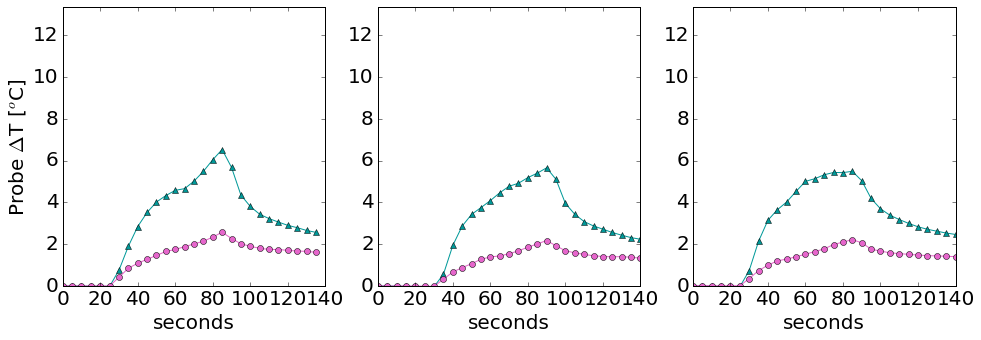

In [1106]:
fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(131)
ax.plot( times1,data1[:,0]-data1[0,0],'-^', color=pos1etc['color'] )
ax.plot( times1,data1[:,1]-data1[0,1],'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
ax.set_ylabel(r'Probe $\Delta$T [$^o$C]')

xlim=ax.get_xlim()
ylim=[0,max(map(np.max,[data1,data2,data3]))-18]
ax.set_ylim(ylim)

ax=fig.add_subplot(132)
ax.plot( times2,data2[:,0]-data2[0,0],'-^', color=pos1etc['color'] )
ax.plot( times2,data2[:,1]-data2[0,1],'-o', color=pos2etc['color'])

ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax=fig.add_subplot(133)
ax.plot( times3,data3[:,0]-data3[0,0],'-^', color=pos1etc['color'] )
ax.plot( times3,data3[:,1]-data3[0,1],'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [424]:
min(map(np.max,[data1,data2,data3]))

21.088000000000001

(18, 32.364000000000004)

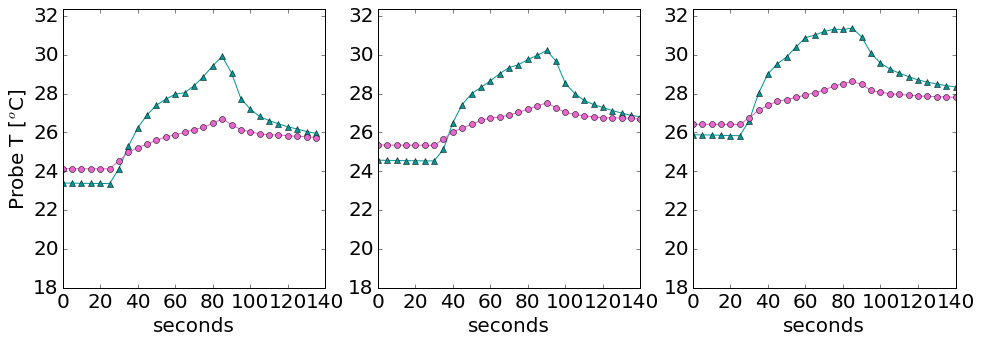

In [1107]:
fig=plt.figure(figsize=(16,5))
ax=fig.add_subplot(131)
ax.plot( times1,data1[:,0],'-^', color=pos1etc['color'] )
ax.plot( times1,data1[:,1],'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
ax.set_ylabel(r'Probe T [$^o$C]')

xlim=ax.get_xlim()
ylim=[18,1+max(map(np.max,[data1,data2,data3]))]
ax.set_ylim(ylim)

ax=fig.add_subplot(132)
ax.plot( times2,data2[:,0],'-^', color=pos1etc['color'] )
ax.plot( times2,data2[:,1],'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax=fig.add_subplot(133)
ax.plot( times3,data3[:,0],'-^', color=pos1etc['color'] )
ax.plot( times3,data3[:,1],'-o', color=pos2etc['color'])
ax.set_xlabel('seconds')
#ax.set_ylabel(r'avg$\Delta$T [$^o$C]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

### Pork data

In [1179]:
def which_mps2ras_ax(aff):
    Ax_M=np.argmax( np.abs(aff.dot([1,0,0,0])) )
    Ax_P=np.argmax( np.abs(aff.dot([0,1,0,0])) )
    Ax_S=np.argmax( np.abs(aff.dot([0,0,1,0])) )
    return (Ax_M,Ax_P,Ax_S)

def get_voxel_orthaxes_projection(aff,shape,MPSoffset=(0,0,0)):
    vox0,vox1,vox2 = tuple(map(lambda x: np.arange(0,x), shape))
    
    #determine which RAS are principle wrt to M,P,S image axes
    (Ax_M,Ax_P,Ax_S)=which_mps2ras_ax(aff)

    nM,nP,nS=shape
    
    Max_mm=aff.dot( np.array( [      vox0 + MPSoffset[0], np.zeros(nM)+MPSoffset[1], np.zeros(nM)+MPSoffset[2], np.ones(nM)]) )[Ax_M]
    Pax_mm=aff.dot( np.array( [np.zeros(nP)+MPSoffset[0], vox1 + MPSoffset[1],       np.zeros(nP)+MPSoffset[2], np.ones(nP)]) )[Ax_P]
    Sax_mm=aff.dot( np.array( [np.zeros(nS)+MPSoffset[0], np.zeros(nS)+MPSoffset[1], vox2 + MPSoffset[2],       np.ones(nS)]) )[Ax_S]
    
    return (Max_mm,Pax_mm,Sax_mm)


In [1315]:
mrifile="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan34_TempCor_20160413.PAR"

(porkdata1,complImP,imPork, porkimes)= MRDataAnalysis.read_TempScan(mrifile,MP_interleaved=True, phase_unwrap=1, pi_val=-0.2)

affPork = imPork.get_affine()
pDim = porkdata1.shape

(Mmm,Pmm,Smm)=get_voxel_orthaxes_projection(affPork,pDim[0:3])
pDim

(112, 112, 8, 40)

In [1178]:
which_mps2ras_ax(affPork)

(0, 2, 1)

In [1132]:
t2wfile=parfil="/Users/Vandiver/Data/sonalleve/sonalleve_flow_041316/scan36_T2wPlan_20160413.PAR"
t2wObj=nibabel.load(t2wfile,scaling='fp')

t2wData=rescaleIm(t2wObj.get_data())
t2aff=t2wObj.get_affine()
t2wvox0=np.arange(0,t2wData.shape[0])
t2wvox1=np.arange(0,t2wData.shape[1])
t2wvox2=np.arange(0,t2wData.shape[2])


(t2Mmm,t2Pmm,t2Smm)=get_voxel_orthaxes_projection(t2aff,t2wData.shape)

t2wData.shape

(320, 320, 5)

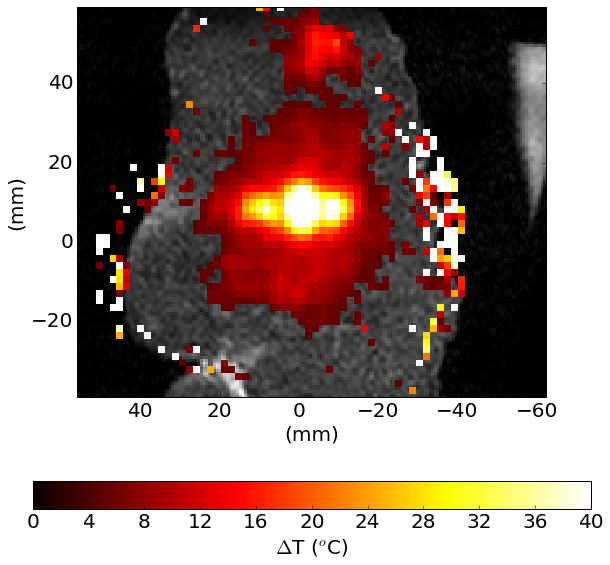

In [1294]:
exP = [ Pmm[0],Pmm[-1],Mmm[-1],Mmm[0]  ]
exT2 = [ t2Pmm[0],t2Pmm[-1],t2Mmm[-1], t2Mmm[0]  ]


temp2d=porkdata1[:,:,4,-8]
maxT=40

plt.figure(figsize=(10,10))
plt.imshow( t2wData[:,:,4], cmap=image.cm.gray,interpolation='None',extent=exT2)


mask = temp2d < 5.0
rgbaIm = image.cm.hot( rescaleIm(temp2d, vmin=0,vmax=maxT,trunc=True) )
rgbaIm[mask,3]=0
im=plt.imshow(rgbaIm, interpolation='none',extent=exP )
imnull=plt.imshow(temp2d,vmin=0,vmax=maxT,cmap=image.cm.hot)
imnull.set_visible(False)

ax=plt.gca()
ax.set_xlim( (exP[1]-exP[0])*np.array([.2, .8]) + exP[0])
ax.set_ylim( (exP[3]-exP[2])*np.array([.3, 0.8]) + exP[2])
ax.set_aspect(1)
ax.set_xlabel('(mm)')
ax.set_ylabel('(mm)')
cb=plt.colorbar(mappable=imnull,orientation='horizontal')
cb.set_label('$\Delta$T ($^o$C)')

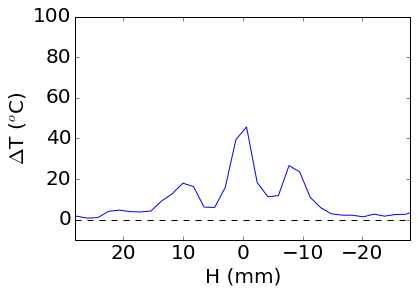

In [1317]:
plt.plot(Pmm,porkdata1[50,:,4,10])
ax=plt.gca()
ax.set_xlim([28,-28])
ax.set_ylim([-10,100])
ax.set_xlabel('H (mm)')
ax.set_ylabel('$\Delta$T ($^o$C)')

plt.plot(ax.get_xlim(),[0,0],'k--')

#plt.plot(porkdata1[55,:,4,-8])

In [1316]:
porkimes[10]

19.93